In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<img src="https://i.imgflip.com/22qkv6.jpg" />

In [2]:
# dataset paths
DS_CAPTURES_1 = "../dataset/captures/captures_1.csv.gz"
DS_CAPTURES_2 = "../dataset/captures/captures_2.csv.gz"
DS_SERVICE_STATES_1 = "../dataset/captures/service_state_1.csv"
DS_SERVICE_STATES_2 = "../dataset/captures/service_state_2.csv"
DS_TEAM_NAMES_1 = "../dataset/captures/team_names_1.csv"
DS_TEAM_NAMES_2 = "../dataset/captures/team_names_2.csv"

DS_TRAFFIC2_OFFLINE = "../dataset/traffic/traffic_2_60sec.csv.gz"
DS_TRAFFIC2_ONLINE = "https://www.dropbox.com/s/ywhb03mvzdo40da/traffic_2_60sec.csv.gz?dl=1"
DS_TRAFFIC2 = DS_TRAFFIC2_OFFLINE if os.path.isfile(DS_TRAFFIC2_OFFLINE) else DS_TRAFFIC2_ONLINE

In [3]:
CAP1 = pd.read_csv(DS_CAPTURES_1, names=["tick", "id", "service", "flags"], compression="gzip")
CAP2 = pd.read_csv(DS_CAPTURES_2, names=["tick", "id", "service", "flags"], compression="gzip")
SS1 = pd.read_csv(DS_SERVICE_STATES_1, names=["tick", "id", "service", "state"])
SS2 = pd.read_csv(DS_SERVICE_STATES_2, names=["tick", "id", "service", "state"])
NAMES1 = pd.read_csv(DS_TEAM_NAMES_1, names=["id", "name"])
NAMES2 = pd.read_csv(DS_TEAM_NAMES_2, names=["id", "name"])
TRAFFIC2 = pd.read_csv(DS_TRAFFIC2, compression="gzip")

SS1["state"] = SS1["state"].astype("category")
SS2["state"] = SS1["state"].astype("category")

In [4]:
figsize=(14,7)

# Descriptive Statistics and Data Wrangling

Our dataset is the pre-processed and downscaled variant of the [public traffic dumps](https://ictf.cs.ucsb.edu/pages/the-2016-2017-ictf.html) of a 24 hours online security competition, along with some metadata.

- **TEAM_NAMES** holds a dataset which map team ids to team names
    - `id` of the team (starting at 1)
    - `name` of the team
- **SERVICE_STATES** holds the state of the service for each team and each service per tick
    - `tick` identifies time slices (they are 3-5 minutes long)
    - `id` holds the team id
    - `service` holds the service id
    - `state` is either `up` or `down` for this team, service and tick
- **CAPTURES** holds the number of stolen flags for each team and each service per tick
    - `tick` identifies time slices (they are 3-5 minutes long)
    - `id` holds the team id
    - `service` holds the service id (for which flags have been stolen)
    - `flags` holds the amount of stolen flags
- **TRAFFIC** holds aggregated traffic data (in 60 seconds slices)
    - `timestamp` is a UNIX timestamp (in seconds) of the packet arrival time
    - `src_team` is the team id of the sender
    - `src_port` is the port of the sender
    - `dst_team` is the team id of the recipient
    - `dst_port` is the port of the recipient
    - `len_payload` holds the tcp or udp payload length in bytes during the aggregated time slice

In [5]:
# dataset dimensions
for ds in [CAP1, CAP2, SS1, SS2, NAMES1, NAMES2, TRAFFIC2]:
    print(ds.shape)

(1230528, 4)
(2522649, 4)
(342360, 4)
(361380, 4)
(317, 2)
(317, 2)
(23036388, 6)


In [6]:
CAP1.head()

,tick,id,service,flags
0,9,231,10004,216
1,9,231,10004,160
2,9,231,10004,20
3,9,231,10004,212
4,9,231,10004,57


In [7]:
SS1.head()

,tick,id,service,state
0,0,216,10004,down
1,0,216,10005,down
2,0,216,10006,down
3,0,216,10007,down
4,0,216,10001,down


In [8]:
TRAFFIC2.head()

,timestamp,src_team,src_port,dst_team,dst_port,len_payload
0,1.488609e+09,101,46544,211,20004,352
1,1.488609e+09,274,50381,4,20011,292
2,1.488609e+09,114,45166,53,20011,657
3,1.488609e+09,203,33090,200,20006,0
4,1.488609e+09,274,56805,244,20001,281


### How many teams, services and ticks are there?

In [9]:
assert len(NAMES1) == len(NAMES2)
unique_services = np.unique(SS1["service"])

n_teams = len(NAMES1)
n_services = len(unique_services)
n_ticks1 = len(np.unique(SS1["tick"]))
n_ticks2 = len(np.unique(SS2["tick"]))

print("Teams: {}".format(n_teams))
print("Services: {} {}".format(n_services, unique_services))
print("Ticks in SS: {} + {}".format(n_ticks1, n_ticks2))
print("Ticks in CAP: {} + {}".format(len(np.unique(CAP1["tick"])), len(np.unique(CAP2["tick"]))))

Teams: 317
Services: 12 [10001 10002 10003 10004 10005 10006 10007 10008 10009 10010 10011 10012]
Ticks in SS: 90 + 95
Ticks in CAP: 81 + 95


There are 90 ticks in round 1 and 95 ticks in round 2.
In the first 9 rounds, no flags were captured (90 - 81).

### Service States

Most of the services were hosted in the cloud. So they should all be up at the beginning.
At ~ tick 60 service 10001 went completly down for almost all teams.

C:\Users\Mario\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


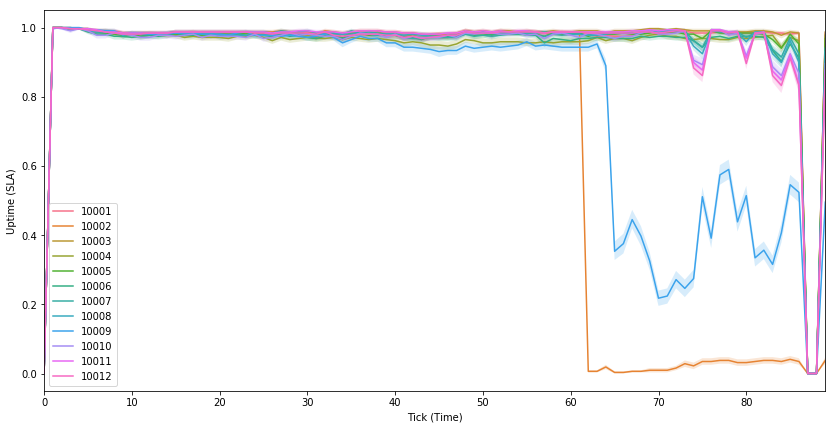

In [10]:
SS1["uptime"] = SS1["state"].cat.codes

plt.figure(figsize=(14,7))

n_ticks = len(np.unique(SS1["tick"]))
ss_ts = SS1.drop("state", axis=1).sort_values(by=["id", "tick", "service"])["uptime"].as_matrix().reshape((317, n_ticks, n_services))
sns.tsplot(ss_ts, condition=unique_services)
plt.xlabel("Tick (Time)")
plt.ylabel("Uptime (SLA)")
plt.show()

### Network Traffic

We extracted the length of the payload (in bytes, without headers) for the communication between teams.

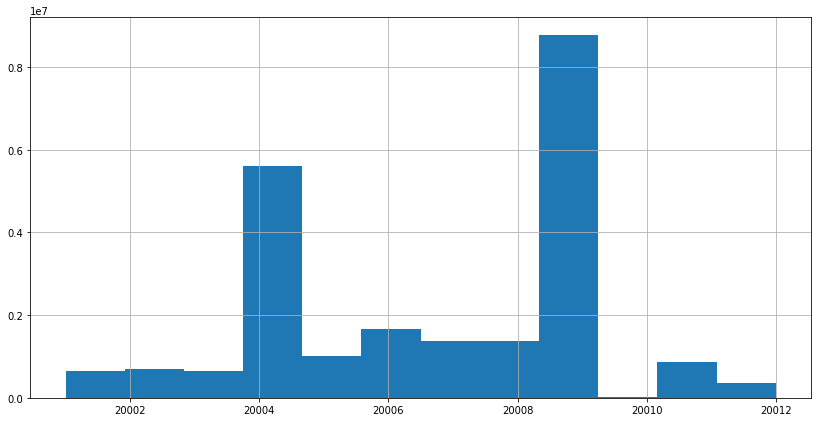

In [11]:
plt.figure(figsize=(14,7))
TRAFFIC2["dst_port"].hist(bins=n_services)
plt.show()

Service 20004 and 20009 seem to get the most attention.

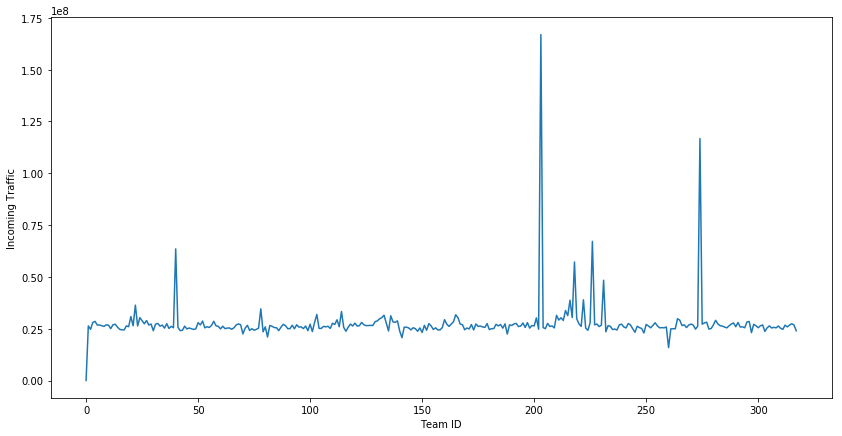

In [12]:
plt.figure(figsize=(14,7))
TRAFFIC2[["dst_team", "len_payload"]].groupby("dst_team", as_index=False, sort=True).sum()["len_payload"].plot()
plt.xlabel("Team ID")
plt.ylabel("Incoming Traffic")
plt.show()

Nearly all teams receive the same amount of incoming traffic, with some outliers.

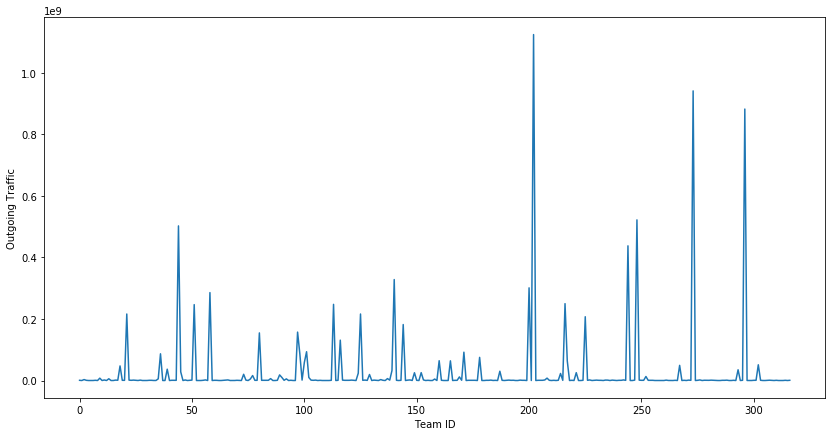

In [13]:
plt.figure(figsize=(14,7))
TRAFFIC2[["src_team", "len_payload"]].groupby("src_team", as_index=False, sort=True).sum()["len_payload"].plot()
plt.xlabel("Team ID")
plt.ylabel("Outgoing Traffic")
plt.show()

The outgoing traffic is rather different. Only some of the teams are really active, will most are rather quite.

#### Observing the high peaks

This CTF event is popular for a huge DDoS attack during the event. (see https://ictf.cs.ucsb.edu/pages/the-2016-2017-ictf-ddos.html)

We can clearly spot the attacking team id here (203: Bushwhackers) and the team which was somewhat involved into the attack (274: LC/BC). Indexes are off by one since the blog starts indexes at zero.

In [14]:
TRAFFIC2[["src_team", "len_payload"]].groupby("src_team", as_index=False, sort=True).sum()["len_payload"].sort_values(ascending=False).head()

202    1123428944
273     940580637
296     881594893
248     521650759
44      502105905
Name: len_payload, dtype: int64

<img src="https://i.imgflip.com/22qkxl.jpg" />

In [15]:
service_state1 = pd.read_csv('../dataset/captures/service_state_1.csv', header=None)
service_state2 = pd.read_csv('../dataset/captures/service_state_2.csv', header=None)

In [16]:
service_state1.columns = ['tick', 'team', 'service' ,'status']
service_state2.columns = ['tick', 'team', 'service' ,'status']

In [17]:
ordered_data1 = pd.pivot_table(service_state1, values = 'status', index=['tick', 'team'], columns='service',aggfunc=(lambda x: x.iloc[0]))
ordered_data2 = pd.pivot_table(service_state2, values = 'status', index=['tick', 'team'], columns='service',aggfunc=(lambda x: x.iloc[0]))

In [18]:
ordered_data1 = ordered_data1.replace(to_replace=' down',value=False)
ordered_data1 = ordered_data1.replace(to_replace=' up',value=True)

In [19]:
ordered_data2 = ordered_data2.replace(' down', False)
ordered_data2 = ordered_data2.replace(' up', True)

In [20]:
ordered_data1.head()

service    10001  10002  10003  10004  10005  10006  10007  10008  10009  \
tick team                                                                  
0    1     False  False  False  False  False  False  False  False  False   
     2     False  False  False  False  False  False  False  False  False   
     3     False  False  False  False  False  False  False  False  False   
     4     False  False  False  False  False  False  False  False  False   
     5     False  False  False  False  False  False  False  False  False   

service    10010  10011  10012  
tick team                       
0    1     False  False  False  
     2     False  False  False  
     3     False  False  False  
     4     False  False  False  
     5     False  False  False

In [21]:
captures1 = pd.read_csv('../dataset/captures/captures_1.csv.gz', header=None)
captures2 = pd.read_csv('../dataset/captures/captures_2.csv.gz', header=None)

In [22]:
#tmp = pd.pivot_table(captures1,val)
captures1.columns = ['tick','flag_captured','service','flag_lost']
captures2.columns = ['tick','flag_captured','service','flag_lost']
def aggregate_captures(data, index_name, values, index ,columns = 'service'):
    tmp = pd.pivot_table(data, values=values, index=index, columns=columns,aggfunc=len).fillna(0).pivot_table(index = index[-1],aggfunc=sum)
    tmp.index.names = [index_name]
    return tmp
flag_captured_1 = aggregate_captures(captures1,'team', 'flag_lost',['tick', 'flag_captured'])
flag_lost_1 = aggregate_captures(captures1,'team', 'flag_captured',['tick', 'flag_lost'])
flag_captured_2 = aggregate_captures(captures2,'team', 'flag_lost',['tick', 'flag_captured'])
flag_lost_2 = aggregate_captures(captures2,'team', 'flag_captured',['tick', 'flag_lost'])

In [23]:
#Team Uptime/service  Flags in/service Flagsout/service
uptime_data1 = ordered_data1.replace(True, 1).replace(False, 0)
uptime_data2 = ordered_data2.replace(True, 1).replace(False, 0)
sla_round_1 = pd.pivot_table(uptime_data1,index='team')
sla_round_2 = pd.pivot_table(uptime_data2,index='team')

In [24]:
# Rename Col's
flag_captured_1.columns = flag_captured_1.columns.map(lambda col: 'captured_' + str(col))
flag_captured_2.columns = flag_captured_2.columns.map(lambda col: 'captured_' + str(col))
flag_lost_1.columns = flag_lost_1.columns.map(lambda col: 'lost_' + str(col))
flag_lost_2.columns = flag_lost_2.columns.map(lambda col: 'lost_' + str(col))
sla_round_1.columns = sla_round_1.columns.map(lambda col: 'sla_' + str(col))
sla_round_2.columns = sla_round_2.columns.map(lambda col: 'sla_' + str(col))
sla_round_1.head()

service,sla_10001,sla_10002,sla_10003,sla_10004,sla_10005,sla_10006,sla_10007,sla_10008,sla_10009,sla_10010,sla_10011,sla_10012
team,,,,,,,,,,,,
1,0.966667,0.677778,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.788889,0.966667,0.966667,0.966667
2,0.966667,0.655556,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.788889,0.966667,0.966667,0.966667
3,0.966667,0.677778,0.966667,0.966667,0.966667,0.955556,0.966667,0.966667,0.800000,0.966667,0.966667,0.966667
4,0.966667,0.677778,0.966667,0.966667,0.966667,0.966667,0.955556,0.955556,0.766667,0.944444,0.933333,0.933333
5,0.966667,0.677778,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.877778,0.966667,0.966667,0.966667


In [25]:
features_1 = pd.concat([sla_round_1,flag_captured_1,flag_lost_1],axis=1).fillna(0)
features_2 = pd.concat([sla_round_2,flag_captured_2,flag_lost_2],axis=1).fillna(0)

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
features1_embedded = TSNE(n_components=2, perplexity=10,n_iter=2000).fit_transform(features_1)

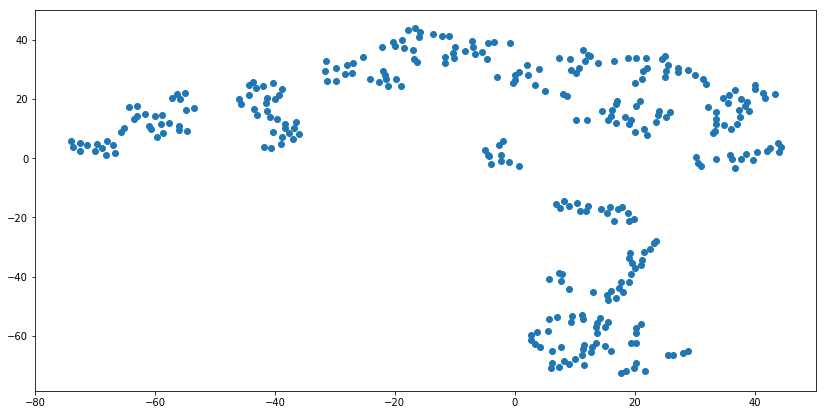

In [27]:
plt.figure(figsize=figsize)
plt.scatter(features1_embedded[:,0],features1_embedded[:,1])
plt.show()

This a T-SNE plot of the flag-capture dataset.

In [28]:
from sklearn.preprocessing import normalize, scale
features1_scaled = TSNE(n_components=2, perplexity=10,n_iter=2000).fit_transform(scale(features_1))
features1_norm = TSNE(n_components=2, perplexity=10,n_iter=2000).fit_transform(normalize(features_1))

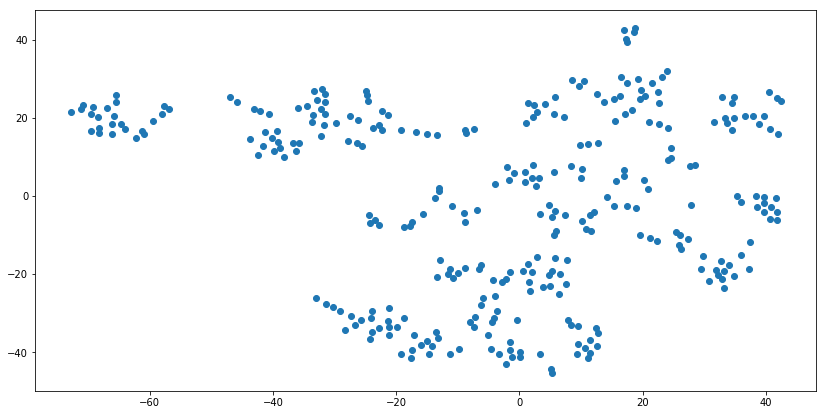

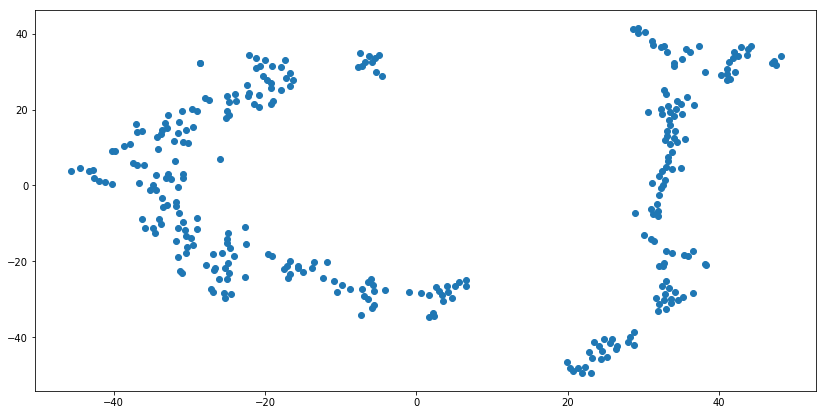

In [29]:
plt.figure(figsize=figsize)
plt.scatter(features1_scaled[:,0],features1_scaled[:,1])
plt.show()
plt.figure(figsize=figsize)
plt.scatter(features1_norm[:,0],features1_norm[:,1])
plt.show()

In [30]:
features_s = scale(features_1)
features_n = normalize(features_1)
features = features_1
fs = [features, features_s, features_n]

### Visual comparison of data transformations

This serves as a visual guideline for further transformations and clustering steps.

The first four plots are the normal raw data.
The next four contains the scaled data.
And the final four plots contain normalized data.

Normalization yields the best results.

new Dataset


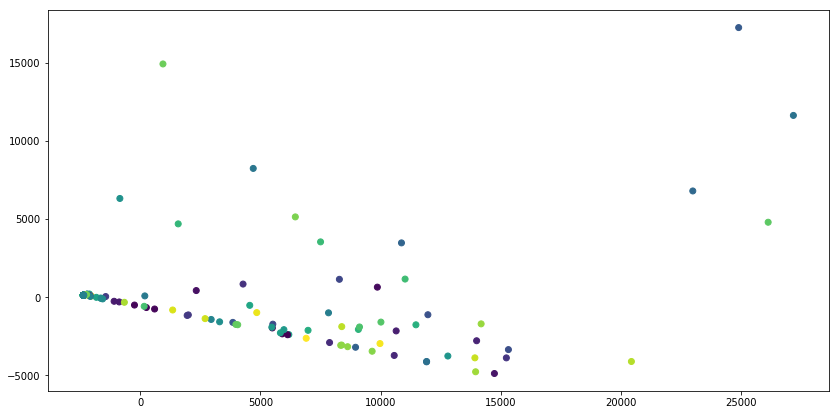

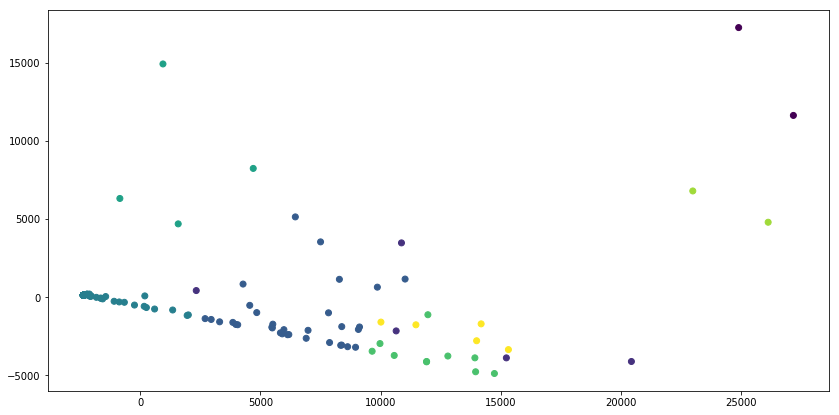

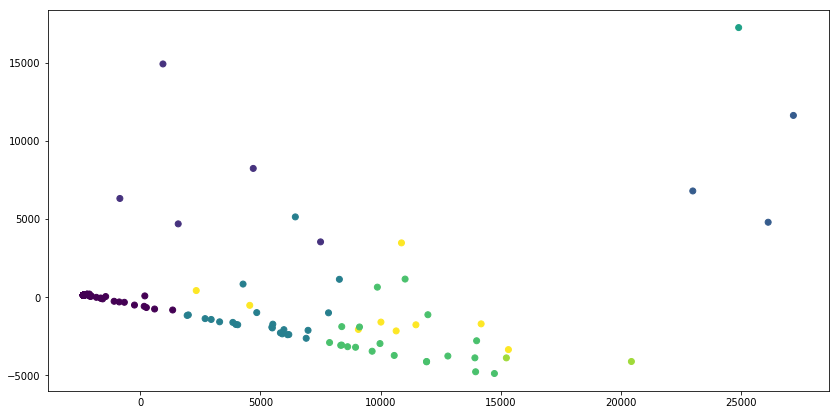

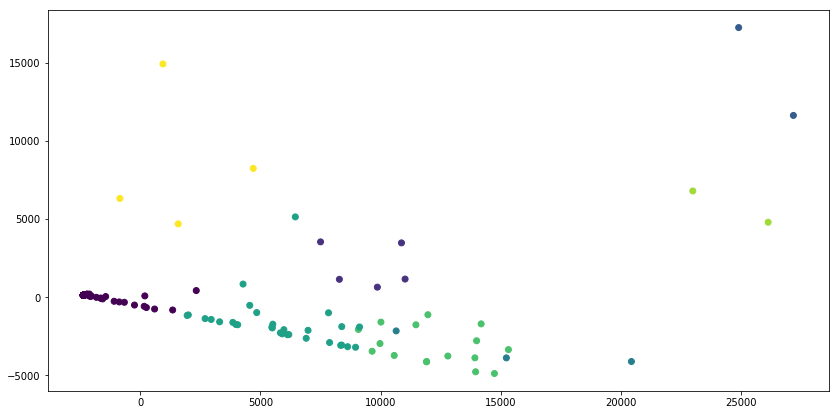

new Dataset


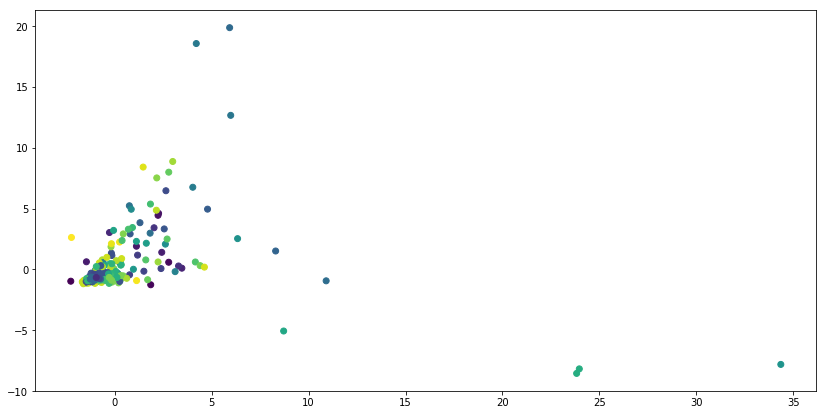

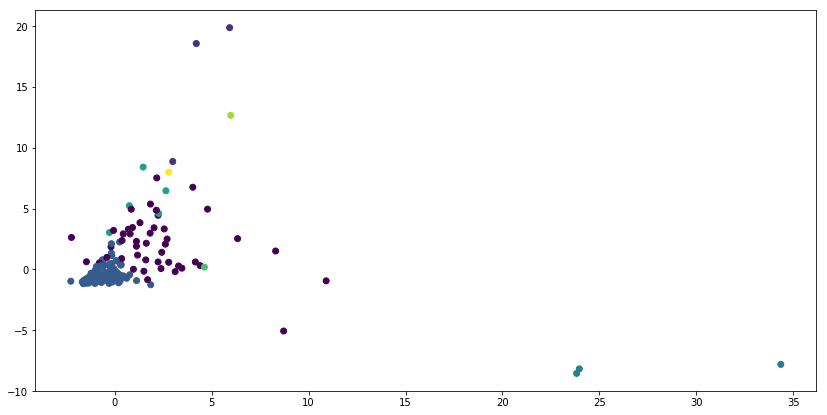

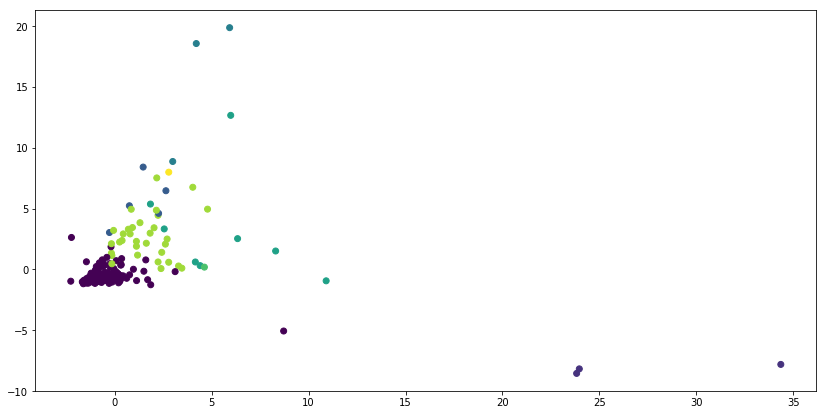

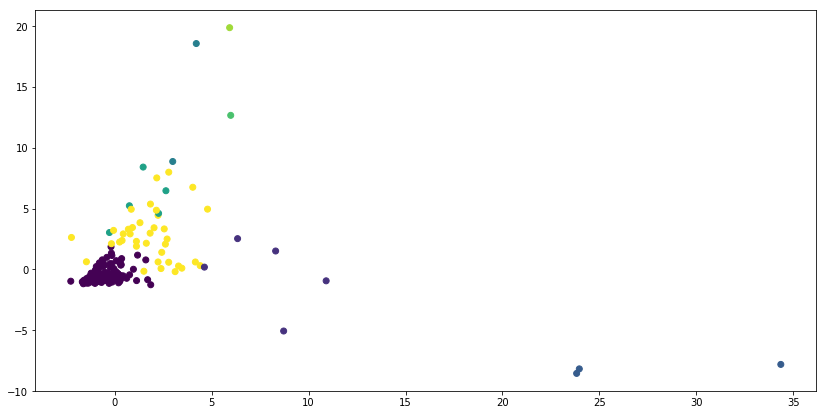

new Dataset


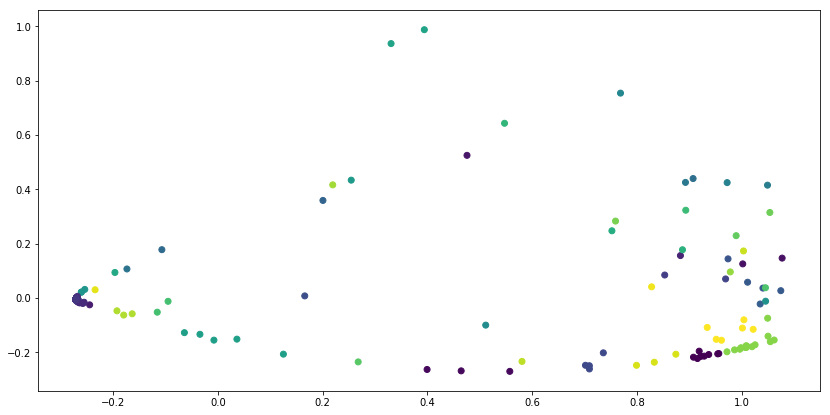

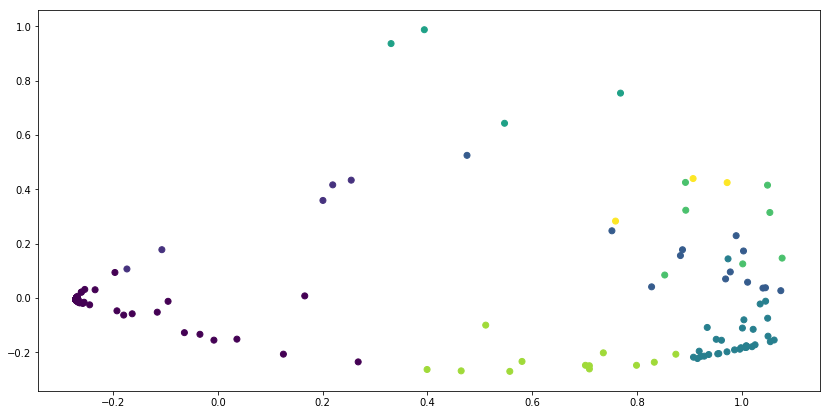

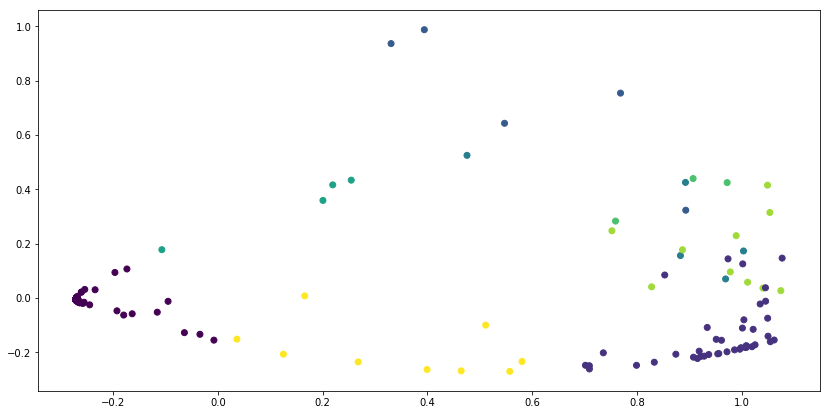

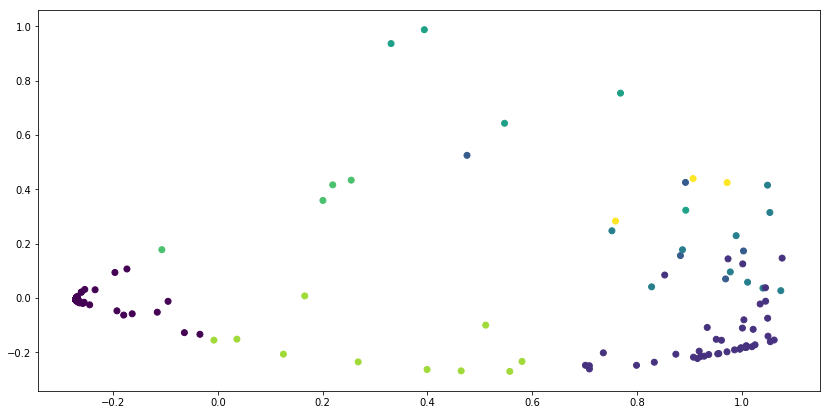

In [31]:
from sklearn.cluster import AffinityPropagation,AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

clusterers = [AffinityPropagation(),AgglomerativeClustering(n_clusters=8),KMeans(),GaussianMixture(n_components=8)]
for dataset in fs:
    print('new Dataset')
    pc = PCA(n_components=2)
    trans = pc.fit_transform(dataset)
    for cl in clusterers:
        if('fit_predict' in dir(cl)):
            labels = cl.fit_predict(dataset)
        else:
            cl.fit(dataset)
            labels = cl.predict(dataset)
        plt.figure(figsize=figsize)
        plt.scatter(trans[:,0],trans[:,1],c=labels)
        plt.show()
        labels = np.array(labels)
        #for group in np.unique(labels):
            #df = pd.DataFrame(dataset[labels ==group])
            #print(df.describe())
        

In [32]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display

In [33]:
traf = pd.read_csv(DS_TRAFFIC2, compression='gzip')
traf = traf.drop(['src_port','timestamp'], axis=1)
traf_agg = traf.groupby(['src_team', 'dst_team', 'dst_port'], as_index=False, sort=False).sum()

In [34]:
traf_out = pd.pivot_table(traf_agg, values='len_payload',index=['src_team'],columns=['dst_port']).fillna(0)
traf_out.columns= traf_out.columns.map(lambda x: 'out_'+str(x) )
traf_in = pd.pivot_table(traf_agg, values='len_payload',index=['dst_team'],columns=['dst_port']).fillna(0).drop(0)
traf_in.columns = traf_in.columns.map(lambda x: 'in_'+str(x) )
total_in = pd.pivot_table(traf_agg, values='len_payload',index=['dst_team']).fillna(0).drop(0)
total_in.columns = total_in.columns.map(lambda x: 'total_in')
total_out = pd.pivot_table(traf_agg, values='len_payload',index=['src_team']).fillna(0)
total_out.columns = total_out.columns.map(lambda x: 'total_out')
flag_captured_ts = pd.pivot_table(captures2, values = 'flag_lost', index = ['flag_captured'], columns = ['tick'], aggfunc=len).fillna(0)
flag_lost_ts = pd.pivot_table(captures2, values = 'flag_captured', index = ['flag_lost'], columns = ['tick'], aggfunc=len).fillna(0)
#flag_lost_ts = pd.pivot_table(captures2, values ='flag_lost', index=['team'], columns=['tick']).fillna(0)
fs=[pd.concat([traf_out,traf_in,total_in,total_out,sla_round_2,flag_captured_2,flag_lost_2], axis=1).fillna(0)]
#fs[0].head()
#for cat in ['src_team', 'dst_team', 'dst_port']:
    #traf_agg[cat] = traf_agg[cat].astype("category")
#traf_agg2 = pd.concat([traf_agg['len_payload'],pd.get_dummies(traf_agg[['src_team', 'dst_team', 'dst_port']])], axis=1)
#traf_agg2.head()
#fs=[traf_agg2]
flag_captured_ts.head()

tick,90,91,92,93,94,95,96,97,98,99,...,175,176,177,178,179,180,181,182,183,184
flag_captured,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,95.0,80.0,373.0,361.0,21.0,225.0,177.0,448.0,110.0,144.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,198.0,238.0,253.0,221.0,181.0,321.0,444.0,335.0,133.0,211.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,271.0,247.0,259.0,229.0,283.0,278.0,259.0,10.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
clust_parameters = {KMeans:{'n_clusters': (2, 20, 1), 'init': ['k-means++','random'], 'n_init': (1, 100, 1), 'max_iter': (100, 1000, 20), 'n_jobs': (1, 8, 1), 'algorithm': ['auto','full','elkan']},
                    AffinityPropagation:{'damping': (0.5, 1.0, 0.01), 'max_iter': (100, 1000, 20), 'convergence_iter': (10, 500, 1)},
                    AgglomerativeClustering:{'n_clusters': (2, 20, 1), 'affinity': ['euclidean','l1','l2','manhattan','cosine'], 'linkage': ['ward','complete','average']},
                    GaussianMixture:{'n_components': (2, 20, 1), 'covariance_type': ['full', 'tied', 'diag', 'spherical'], 'max_iter': (100, 1000, 50), 'n_init': (1, 10, 1), 'init_params': ['kmeans','random']}}
curr_labels = [0]
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from inspect import getargspec, signature, getfullargspec
@interact(clusterer = {'AffinityPropagation':AffinityPropagation,
                       'AgglomerativeClustering':AgglomerativeClustering,
                       'KMeans':KMeans,
                       'GaussianMixture':GaussianMixture})
def int_plot( clusterer):
    cl_f = clusterer
    d2 = clust_parameters[cl_f]
    @interact_manual(dimensions=(2,fs[0].shape[1],1),**(d2))
    def inner_func(**kwargs):
        global curr_labels
        dims = kwargs.pop('dimensions')
        cl = cl_f(**kwargs)
        feat = fs[0]
        
        pc = PCA(n_components=dims)
        trans = pc.fit_transform(normalize(feat))
        if('fit_predict' in dir(cl)):
            labels = cl.fit_predict(trans)
        else:
            cl.fit(trans)
            labels = cl.predict(trans)
        fig = plt.figure(figsize=figsize)
        cmap = cm.get_cmap('gist_rainbow')
        cmaplist = [cmap(i/(max(labels))) for i in range(max(labels)+1)]
        cmap = ListedColormap(cmaplist,name='askdjsaldsajlf')
        plt.figure(figsize=(14,7))
        plt.scatter(trans[:,0],trans[:,1],c=labels,cmap=cmap)
        plt.colorbar()
        plt.show()
        curr_labels = labels
        return
    return
    
    
    

interactive(children=(Dropdown(description='clusterer', options={'AffinityPropagation': <class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>, 'AgglomerativeClustering': <class 'sklearn.cluster.hierarchical.AgglomerativeClustering'>, 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'GaussianMixture': <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>}, value=<class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>), Output()), _dom_classes=('widget-interact',))

The graphic above shows the different clusters along the first two Principle Components the color just differentiates the Clusters and doesnt have any other value encoded.

# IMPORTANT: Run the following cell after the each clustering step above.

... due to the difficulty of making four nested interactive plots.

In [38]:
from ipywidgets import fixed
clust_parameters = {KMeans:{'n_clusters': (2, 20, 1), 'init': ['k-means++','random'], 'n_init': (1, 100, 1), 'max_iter': (100, 1000, 20), 'n_jobs': (1, 8, 1), 'algorithm': ['auto','full','elkan']},
                    AffinityPropagation:{'damping': (0.5, 1.0, 0.01), 'max_iter': (100, 1000, 20), 'convergence_iter': (10, 500, 1)},
                    AgglomerativeClustering:{'n_clusters': (2, 20, 1), 'affinity': ['euclidean','l1','l2','manhattan','cosine'], 'linkage': ['ward','complete','average']},
                    GaussianMixture:{'n_components': (2, 20, 1), 'covariance_type': ['full', 'tied', 'diag', 'spherical'], 'max_iter': (100, 1000, 50), 'n_init': (1, 10, 1), 'init_params': ['kmeans','random']}}
@interact( cluster = dict([('Cluster ' + str(x), x )for x in range(max(curr_labels)+1) ]), clusterer = {'AffinityPropagation':AffinityPropagation,
                       'AgglomerativeClustering':AgglomerativeClustering,
                       'KMeans':KMeans,
                       'GaussianMixture':GaussianMixture})
def int_plot(cluster, clusterer):
    cl_f = clusterer
    max_elements = np.array([curr_labels==cluster],dtype=int).sum()
    print("Number of elements: {}".format(max_elements))
    print()
    d2 = clust_parameters[cl_f]
    if 'n_components' in d2.keys():
        tmp_x,_,tmp_y = d2['n_components']
        d2['n_components']= (min(tmp_x,max_elements),max_elements,tmp_y)
    if 'n_clusters' in d2.keys():
        tmp_x,tmp_y,_ = d2['n_clusters']
        d2['n_clusters']= (min(tmp_x,max_elements),max_elements,tmp_y)
    @interact_manual(dimensions=(2,fs[0].shape[1],1),
                     cluster = fixed(cluster),
                     **(d2))
    def inner_func(**kwargs):
        global curr_labels
        dims = kwargs.pop('dimensions')
        curr_cl = kwargs.pop('cluster')
        cl = cl_f(**kwargs)
        feat = (fs[0])[curr_labels == curr_cl]
        pc = PCA(n_components=dims)
        trans = pc.fit_transform(normalize(feat))
        if('fit_predict' in dir(cl)):
            labels = cl.fit_predict(trans)
        else:
            cl.fit(trans)
            labels = cl.predict(trans)
        fig = plt.figure(figsize=figsize)
        cmap = cm.get_cmap('gist_rainbow')
        cmaplist = [cmap(i/(max(labels))) for i in range(max(labels)+1)]
        cmap = ListedColormap(cmaplist,name='askdjsaldsajlf')
        plt.figure(figsize=(14,7))
        plt.scatter(trans[:,0],trans[:,1],c=labels,cmap=cmap)
        plt.colorbar()
        plt.show()
        #print details
        data = flag_lost_ts.values[pd.Series(flag_lost_ts.index).isin(np.arange(len(curr_labels))[curr_labels == cluster])]

        if data is []:
            print('no Flags Lost by Cluster')
        else:
            plt.figure(figsize=(14,7))
            plt.title('Flags lost by Cluster')
            sns.tsplot(flag_lost_ts[pd.Series(flag_lost_ts.index).isin(np.arange(len(curr_labels))[curr_labels == cluster]).values].values,ci='sd')
            plt.show()
        data = flag_captured_ts.values[pd.Series(flag_captured_ts.index).isin(np.arange(len(curr_labels))[curr_labels == cluster]).values]

        if data is []:
            print('no Flags Captured by Cluster')
        else:
            plt.figure(figsize=(14,7))
            plt.title('Flags captured by Cluster')
            sns.tsplot(data,ci='sd')
            plt.show()
        return
    return

interactive(children=(Dropdown(description='cluster', options={'Cluster 0': 0, 'Cluster 1': 1, 'Cluster 2': 2, 'Cluster 3': 3, 'Cluster 4': 4, 'Cluster 5': 5, 'Cluster 6': 6, 'Cluster 7': 7, 'Cluster 8': 8}, value=0), Dropdown(description='clusterer', options={'AffinityPropagation': <class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>, 'AgglomerativeClustering': <class 'sklearn.cluster.hierarchical.AgglomerativeClustering'>, 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'GaussianMixture': <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>}, value=<class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>), Output()), _dom_classes=('widget-interact',))